Selected Features: ['AMT', 'DOSE', 'ADDL', 'D25BASE', 'SEASON', 'Sunlight Exposure (Hours/Day)', 'Dietary Vitamin D Intake (IU/day)']


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
🔹 Random Forest Accuracy: 99.81%
🔹 ANN Accuracy: 91.41%
🔹 Random Forest MSE: 9.7700, MAE: 0.6814, R²: 0.9981
🔹 ANN MSE: 445.1475, MAE: 13.3683, R²: 0.9141


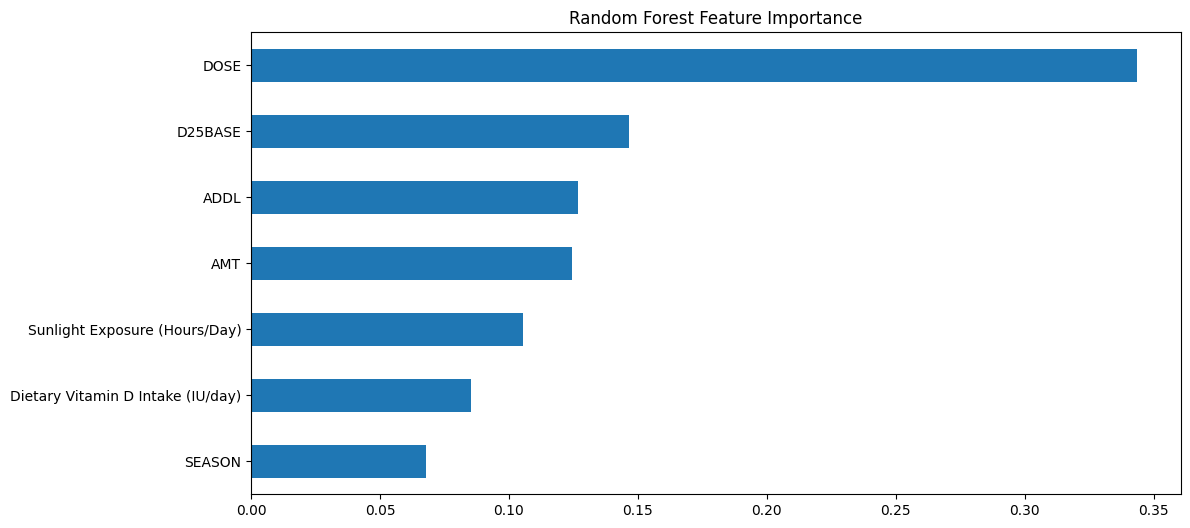

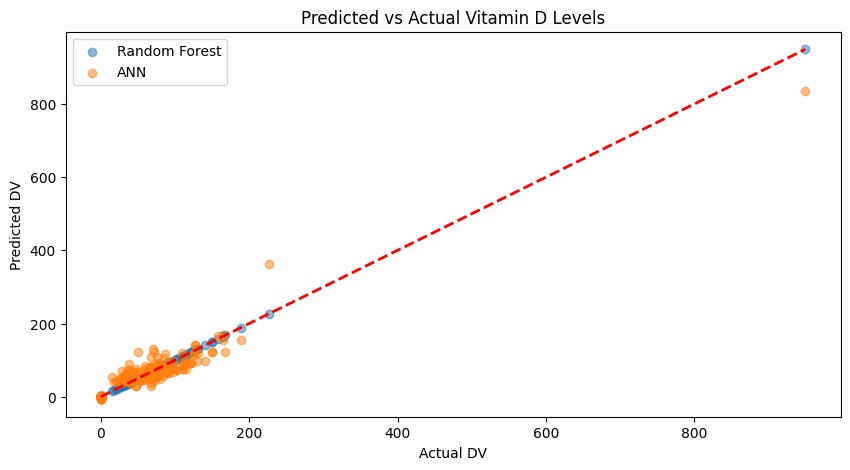

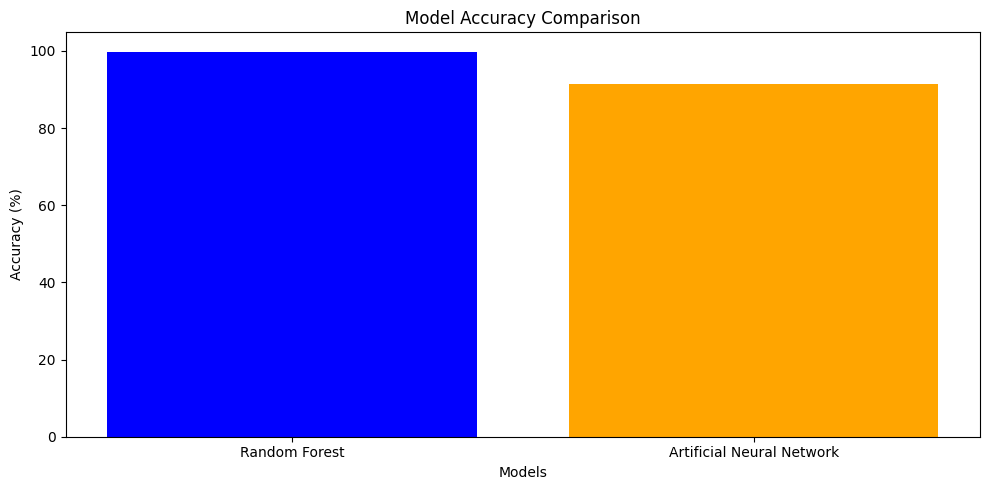

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
from tensorflow import keras

# Load dataset
df = pd.read_csv("/content/datasets.csv")  # Replace with actual dataset path

# Drop rows with missing values
df.dropna(inplace=True)

# Convert categorical variables to strings to avoid encoding issues
df = df.astype(str)

# Encoding categorical variables
categorical_cols = ["SEX", "SEASON", "CONTINENTS", "Skin Type (Fitzpatrick Scale)"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert all remaining columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with remaining NaN values after conversion
df.dropna(inplace=True)

# Define features (X) and target variable (y)
X = df.drop(columns=["DV", "ID", "TIME"])
y = df["DV"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature Selection using Random Forest
selector = SelectFromModel(RandomForestRegressor(n_estimators=500, random_state=42), threshold="median")
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Keep only selected feature names
selected_features = df.drop(columns=["DV", "ID", "TIME"]).columns[selector.get_support()]
print("Selected Features:", list(selected_features))

# Hyperparameter tuning for Random Forest
param_distributions = {
    'n_estimators': [500, 800, 1000, 1200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42]
}

rf_model = RandomForestRegressor()

# RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions,
    n_iter=30,  # Increased n_iter for better tuning
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=2,
    random_state=42
)

random_search_rf.fit(X_train_selected, y_train)

# Best Random Forest model
rf_best_model = random_search_rf.best_estimator_

# Train Artificial Neural Network (ANN)
ann_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_selected.shape[1],)),  # Fix for Keras input warning
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Regression output
])

ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train ANN model
history = ann_model.fit(X_train_selected, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0)

# Predictions for Random Forest and ANN
rf_pred = rf_best_model.predict(X_test_selected)
ann_pred = ann_model.predict(X_test_selected).flatten()

# Evaluation Metrics
rf_mse = mean_squared_error(y_test, rf_pred)
ann_mse = mean_squared_error(y_test, ann_pred)

rf_mae = mean_absolute_error(y_test, rf_pred)
ann_mae = mean_absolute_error(y_test, ann_pred)

rf_r2 = r2_score(y_test, rf_pred)
ann_r2 = r2_score(y_test, ann_pred)

# Calculate accuracy percentage (R² * 100)
rf_accuracy = rf_r2 * 100
ann_accuracy = ann_r2 * 100

# Accuracy and Error Display
print(f"🔹 Random Forest Accuracy: {rf_accuracy:.2f}%")
print(f"🔹 ANN Accuracy: {ann_accuracy:.2f}%")
print(f"🔹 Random Forest MSE: {rf_mse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")
print(f"🔹 ANN MSE: {ann_mse:.4f}, MAE: {ann_mae:.4f}, R²: {ann_r2:.4f}")

# Feature Importance (for Random Forest)
feature_importances_rf = pd.Series(rf_best_model.feature_importances_, index=selected_features)

# Plotting Feature Importances
plt.figure(figsize=(12, 6))
feature_importances_rf.sort_values().plot(kind='barh', title='Random Forest Feature Importance')
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, rf_pred, label='Random Forest', alpha=0.5)
plt.scatter(y_test, ann_pred, label='ANN', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel("Actual DV")
plt.ylabel("Predicted DV")
plt.title("Predicted vs Actual Vitamin D Levels")
plt.legend()
plt.show()

# Accuracy Comparison
models = ['Random Forest', 'Artificial Neural Network']
accuracy_scores = [rf_accuracy, ann_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracy_scores, color=['blue', 'orange'])
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")

plt.tight_layout()
plt.show()
